<a href="https://colab.research.google.com/github/rchllllll/cp5105-capstone-proj/blob/main/visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # # reference: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
!cp /content/drive/MyDrive/colab/dataset.py .
!cp /content/drive/MyDrive/colab/config.py .
# !cp /content/drive/MyDrive/colab/model.py .

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import time
import pickle
import os
from pathlib import Path
import time 
import collections

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader 
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from dataset import SiameseDataset
# from model import SiameseModel

# to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

## training vs validation loss 

In [3]:
e = 300
b = 16
l = 0.0001 
n = 1028

eb = EMB_SIZE = 10
m = 'siamese_network_binary'

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
DIR = "/content/drive/MyDrive/capstone/model/"
entries = [entry for entry in os.listdir(DIR) if f'b{b}_lr{l}_num{n}_emb{eb}.' in entry and m in entry]
entries

['siamese_network_binary_e0_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e1_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e2_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e3_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e6_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e9_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e10_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e12_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e22_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e23_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e31_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e36_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e54_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e61_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e92_b16_lr0.0001_num1028_emb10.pth',
 'siamese_network_binary_e97_b16_lr0.0001_num1028_emb10.pth',
 'siamese_netw

In [5]:
train_dataset = pickle.load(open(f'/content/drive/MyDrive/capstone/data/train_dataset_b{b}_lr{l}_num{n}_emb{eb}.pickle', 'rb'))
val_dataset = pickle.load(open(f'/content/drive/MyDrive/capstone/data/val_dataset_b{b}_lr{l}_num{n}_emb{eb}.pickle', 'rb'))

train_loss_history = pickle.load(open(f'/content/drive/MyDrive/capstone/model/train_loss_history_{m}_e{e}_b{b}_lr{l}_num{n}_emb{eb}.pickle', 'rb'))
val_loss_history = pickle.load(open(f'/content/drive/MyDrive/capstone/model/val_loss_history_{m}_e{e}_b{b}_lr{l}_num{n}_emb{eb}.pickle', 'rb'))

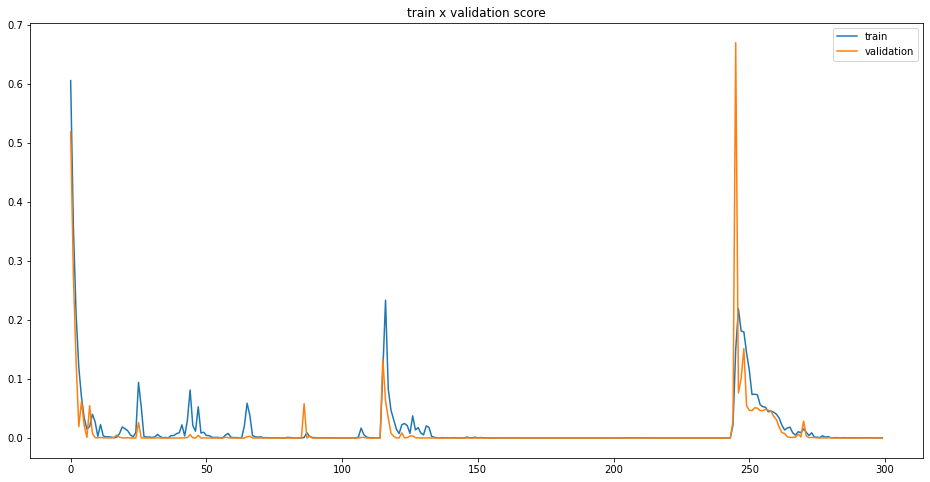

In [6]:
# how did the model do? 
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(16)

threshold = 1.6

plt.plot(range(len(train_loss_history)), [np.mean([i for i in x if i < threshold]) for x in train_loss_history], label="train")
plt.plot(range(len(val_loss_history)), [np.mean([i for i in x if i < threshold]) for x in val_loss_history], label="validation")

plt.title('train x validation score')
plt.legend()
plt.show()

In [7]:
# class SiameseModel(nn.Module):
  
#   def __init__(self, emb_size = EMB_SIZE): 
#     super(SiameseModel, self).__init__()

#     self.weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
#     self.siamese = efficientnet_v2_s(weights=self.weights)
#     self.siamese.classifier = nn.Sequential(
#         nn.Linear(self.siamese.classifier[1].in_features, 500),
#         nn.ReLU(inplace = True),
#         nn.Linear(500, emb_size)
#     )
#     self.classifier = nn.Sequential(
#         nn.Linear(emb_size, 1),
#         nn.Sigmoid()
#     )

#   def forward(self, img1, img2): 
#     preprocess = self.weights.transforms()
#     x1 = preprocess(img1)
#     x2 = preprocess(img2)
#     out1 = self.siamese(x1)
#     out2 = self.siamese(x2)
#     return out1, out2

In [8]:
class SiameseModel(nn.Module):
  
  def __init__(self, emb_size = EMB_SIZE): 
    super(SiameseModel, self).__init__()

    self.weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
    self.siamese = efficientnet_v2_s(weights=self.weights)
    self.siamese.classifier = nn.Sequential(
        nn.Linear(self.siamese.classifier[1].in_features, 500),
        nn.ReLU(inplace = True),
        nn.Linear(500, emb_size)
    )
    self.classifier = nn.Sequential(
        nn.Linear(emb_size, 1),
        nn.Sigmoid()
    )

  def forward(self, img1, img2): 
    preprocess = self.weights.transforms()
    x1 = preprocess(img1)
    x2 = preprocess(img2)
    out1 = self.siamese(x1)
    out2 = self.siamese(x2)
    # multiply to get combined feature vector representing the similarity btwn the two
    combined_features = out1 * out2
    output = self.classifier(combined_features)
    return output

In [9]:
e = 100

model = SiameseModel()
model.load_state_dict(torch.load(f'/content/drive/MyDrive/capstone/model/{m}_e{e}_b{b}_lr{l}_num{n}_emb{eb}.pth'))
model.to(DEVICE)

baseline_model = SiameseModel()
baseline_model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

SiameseModel(
  (siamese): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d

In [10]:
TEST_DATA_DIR = "./drive/MyDrive/capstone/test/"
TEST_SAMPLES = 512

transforms = nn.Sequential(
  T.Resize((228, 228))
)

testset = SiameseDataset(images_folder_path=TEST_DATA_DIR, transform=transforms, num_samples=TEST_SAMPLES)
testloader = DataLoader(testset, shuffle = True, batch_size = b)

threshold = 0.5

In [11]:
# model_correct = 0 
# baseline_model_correct = 0 
# total = 0

# with torch.no_grad():
#   for _, vdata in enumerate(testloader):
#     vimg0, vimg1, _, _, vlabel = vdata
#     vimg0, vimg1, vlabel = vimg0.to(DEVICE), vimg1.to(DEVICE), vlabel.to(DEVICE)

#     vout1, vout2 = model(vimg0, vimg1)
#     b_vout1, b_vout2 = baseline_model(vimg0, vimg1)

#     voutput = F.pairwise_distance(vout1, vout2)
#     b_voutput = F.pairwise_distance(b_vout1, b_vout2)
    
#     model_correct += torch.count_nonzero(vlabel == (voutput > threshold)).item()
#     baseline_model_correct += torch.count_nonzero(vlabel == (b_voutput > threshold)).item()
    
#     total += len(vlabel)

# print('model accuracy is', model_correct/total)
# print('baseline model accuracy is', baseline_model_correct/total)

In [12]:
model_correct = 0 
baseline_model_correct = 0 
total = 0
img0_wrong = None
img1_wrong = None

with torch.no_grad():
  for _, vdata in enumerate(testloader):
    vimg0, vimg1, _, _, vlabel = vdata
    vimg0, vimg1, vlabel = vimg0.to(DEVICE), vimg1.to(DEVICE), vlabel.to(DEVICE)

    voutput = model(vimg0, vimg1).squeeze(1)
    b_voutput = baseline_model(vimg0, vimg1).squeeze(1)
    
    model_correct += torch.count_nonzero(vlabel == (voutput > threshold)).item()
    baseline_model_correct += torch.count_nonzero(vlabel == (b_voutput > threshold)).item()

    if img0_wrong is None: 
      img0_wrong = torch.index_select(vimg0, 0, torch.where(vlabel != (voutput > threshold))[0])
    else: 
      curr_img0_wrong = torch.index_select(vimg0, 0, torch.where(vlabel != (voutput > threshold))[0])
      img0_wrong = torch.vstack((img0_wrong, curr_img0_wrong))

    if img1_wrong is None: 
      img1_wrong = torch.index_select(vimg1, 0, torch.where(vlabel != (voutput > threshold))[0])
    else: 
      curr_img1_wrong = torch.index_select(vimg1, 0, torch.where(vlabel != (voutput > threshold))[0])
      img1_wrong = torch.vstack((img1_wrong, curr_img1_wrong))
    
    total += len(vlabel)

print('model accuracy is', model_correct/total)
print('baseline model accuracy is', baseline_model_correct/total)

model accuracy is 0.798828125
baseline model accuracy is 0.4765625


for which pairs of images were the model not able to predict correctly? 

In [13]:
def show(imgs):
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
  fix.set_figheight(8)
  fix.set_figwidth(15)
  for i, img in enumerate(imgs):
    img = T.ToPILImage()(img.to(DEVICE))
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

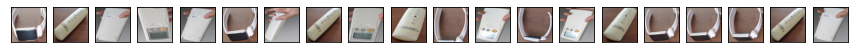

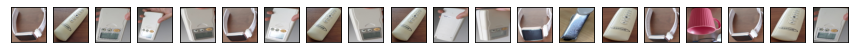

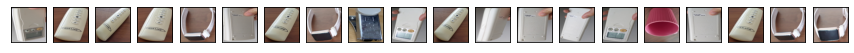

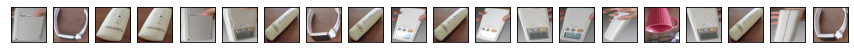

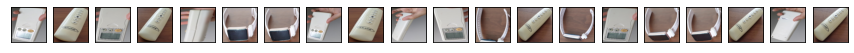

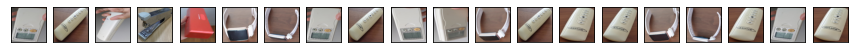

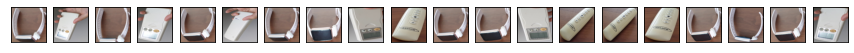

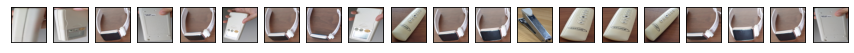

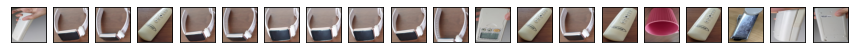

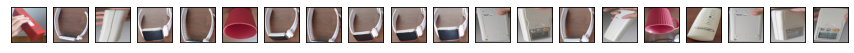

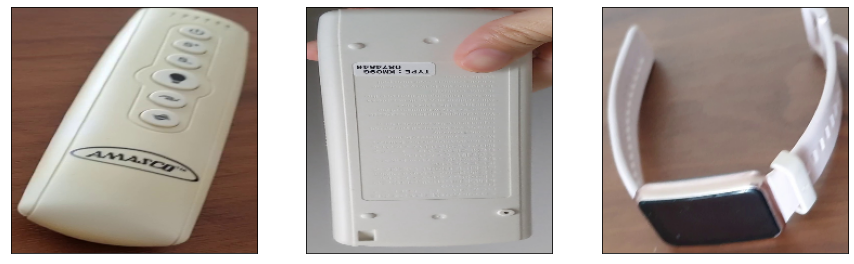

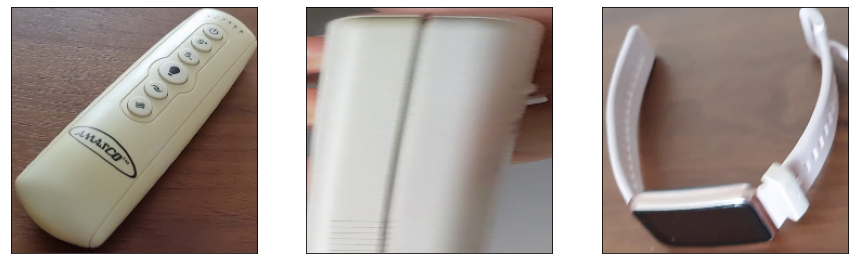

In [15]:
num_img_per_row = 20
num_loop = img0_wrong.shape[0] // num_img_per_row + 1 
for i in range(num_loop):
  show(img0_wrong[i*num_img_per_row:i*num_img_per_row+num_img_per_row])
  show(img1_wrong[i*num_img_per_row:i*num_img_per_row+num_img_per_row])

what kinds of images were the model trained on? 

tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1])
time 0.9073417519999989


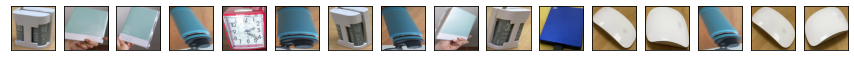

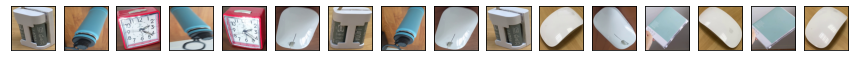

In [ ]:
start = time.process_time()

sampleloader = DataLoader(train_dataset, batch_size = 16)
dataiter = iter(sampleloader)
samplebatch = next(dataiter)

x, y, _, _, z = samplebatch
show(x)
show(y)
print(z)

print('time', time.process_time() - start)

In [ ]:
x.shape

torch.Size([16, 3, 228, 228])

In [ ]:
start = time.process_time()

sampleloader = DataLoader(testset, batch_size = 16)
dataiter = iter(sampleloader)
samplebatch = next(dataiter)

x, y, _, _, z = samplebatch
show(x)
show(y)
print(z)

print('time', time.process_time() - start)

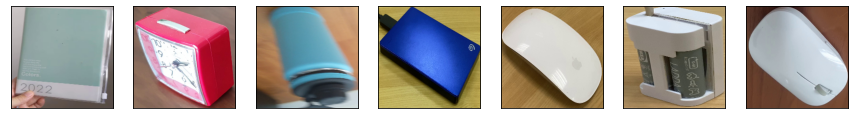

In [ ]:
images_folder_path = "./drive/MyDrive/capstone/train/"
class_names = [name for name in os.listdir(images_folder_path) if os.path.isdir(os.path.join(images_folder_path, name))]
all_images = [[class_names[i] + "/" + name for name in os.listdir(images_folder_path + class_names[i])] for i in range(len(class_names))]

transforms = nn.Sequential(
  T.Resize((228, 228))
)

final = [all_images[i][0] for i in range(len(class_names))]
first = transforms(read_image(str(Path(images_folder_path) / final[0])).unsqueeze(0))
for i in final[1:]: 
  first = torch.vstack((first, transforms(read_image(str(Path(images_folder_path) / i)).unsqueeze(0))))
show(first)

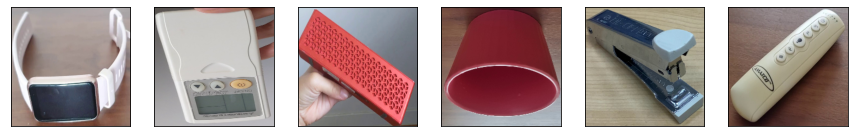

In [ ]:
images_folder_path = "./drive/MyDrive/capstone/test/"
class_names = [name for name in os.listdir(images_folder_path) if os.path.isdir(os.path.join(images_folder_path, name))]
all_images = [[class_names[i] + "/" + name for name in os.listdir(images_folder_path + class_names[i])] for i in range(len(class_names))]

transforms = nn.Sequential(
  T.Resize((228, 228))
)

final = [all_images[i][0] for i in range(len(class_names))]
first = transforms(read_image(str(Path(images_folder_path) / final[0])).unsqueeze(0))
for i in final[1:]: 
  first = torch.vstack((first, transforms(read_image(str(Path(images_folder_path) / i)).unsqueeze(0))))
show(first)

## distance distribution of feature embeddings from siamese network

In [ ]:
trainloader = DataLoader(train_dataset, batch_size = 16)

In [ ]:
img0_l = []
img1_l = []
label_l = []

b_img0_l = []
b_img1_l = []

model.train(False)
with torch.no_grad(): 
  for _, data in enumerate(trainloader):
    img0, img1, _, _, label = data
    img0, img1, label = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE)

    out0, out1 = model(img0, img1)
    b_out0, b_out1 = baseline_model(img0, img1)

    img0_l.extend(out0.cpu().detach().numpy())
    img1_l.extend(out1.cpu().detach().numpy())
    b_img0_l.extend(b_out0.cpu().detach().numpy())
    b_img1_l.extend(b_out1.cpu().detach().numpy())
    label_l.extend(label.cpu().detach().numpy())

In [ ]:
len(img0_l), len(img1_l), len(b_img0_l), len(b_img1_l), len(label_l)

(822, 822, 822, 822, 822)

In [ ]:
euclidean_distance = F.pairwise_distance(torch.from_numpy(np.array(img0_l)), torch.from_numpy(np.array(img1_l)))
b_euclidean_distance = F.pairwise_distance(torch.from_numpy(np.array(b_img0_l)), torch.from_numpy(np.array(b_img1_l)))

euclidean_distance.shape, b_euclidean_distance.shape

(torch.Size([822]), torch.Size([822]))

In [ ]:
l = torch.from_numpy(np.array(label_l)) 
mask = l == 0
indices = torch.nonzero(l)

min_x = torch.min(euclidean_distance)
max_x = torch.max(euclidean_distance)
b_min_x = torch.min(b_euclidean_distance)
b_max_x = torch.max(b_euclidean_distance)

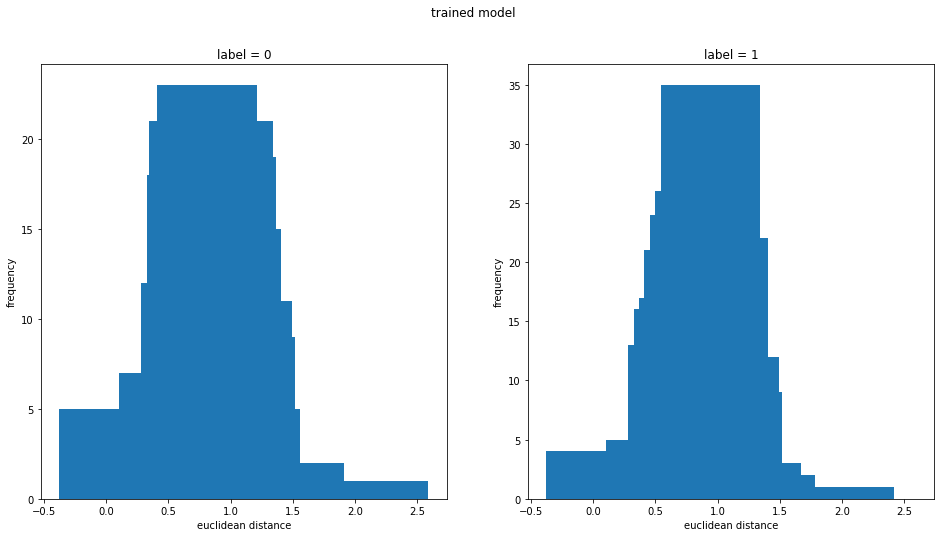

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

bins = 100
x = range(bins)

torchhist = torch.histogram(input=euclidean_distance[indices], bins=bins, range=(min_x.item(), max_x.item()))
ax[0].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[0].set_xlabel('euclidean distance')
ax[0].set_ylabel('frequency')
ax[0].set_title('label = 0')

torchhist = torch.histogram(input=euclidean_distance[~indices], bins=bins, range=(min_x.item(), max_x.item()))
ax[1].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[1].set_xlabel('euclidean distance')
ax[1].set_ylabel('frequency')
ax[1].set_title('label = 1')

plt.suptitle('trained model')
plt.show()

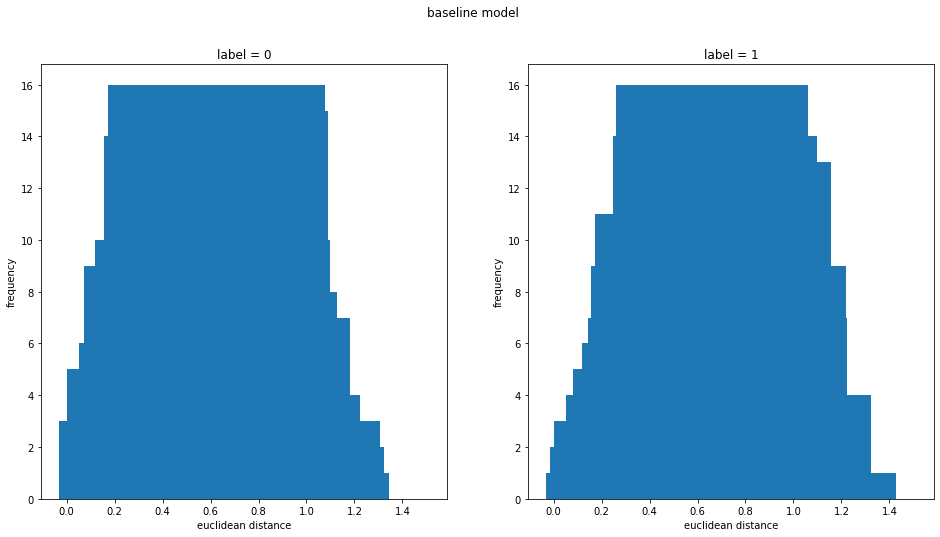

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

bins = 100
x = range(bins)

torchhist = torch.histogram(input=b_euclidean_distance[indices], bins=bins, range=(b_min_x.item(), b_max_x.item()))
ax[0].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[0].set_xlabel('euclidean distance')
ax[0].set_ylabel('frequency')
ax[0].set_title('label = 0')

torchhist = torch.histogram(input=b_euclidean_distance[~indices], bins=bins, range=(b_min_x.item(), b_max_x.item()))
ax[1].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[1].set_xlabel('euclidean distance')
ax[1].set_ylabel('frequency')
ax[1].set_title('label = 1')

plt.suptitle('baseline model')
plt.show()

In [ ]:
# looking into cosine similiarity 
cosine_sim = F.cosine_similarity(torch.from_numpy(np.array(img0_l)), torch.from_numpy(np.array(img1_l)))
b_cosine_sim = F.cosine_similarity(torch.from_numpy(np.array(b_img0_l)), torch.from_numpy(np.array(b_img1_l)))

cosine_sim.shape, b_cosine_sim.shape

(torch.Size([822]), torch.Size([822]))

In [ ]:
min_x = torch.min(cosine_sim)
max_x = torch.max(cosine_sim)
b_min_x = torch.min(b_cosine_sim)
b_max_x = torch.max(b_cosine_sim)

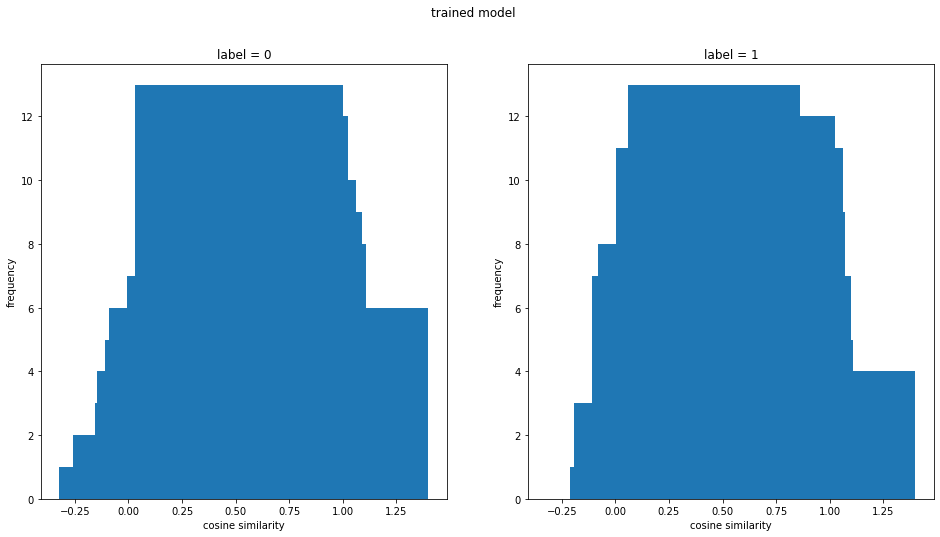

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

bins = 100
x = range(bins)

torchhist = torch.histogram(input=cosine_sim[indices], bins=bins, range=(min_x.item(), max_x.item()))
ax[0].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[0].set_xlabel('cosine similarity')
ax[0].set_ylabel('frequency')
ax[0].set_title('label = 0')

torchhist = torch.histogram(input=cosine_sim[~indices], bins=bins, range=(min_x.item(), max_x.item()))
ax[1].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[1].set_xlabel('cosine similarity')
ax[1].set_ylabel('frequency')
ax[1].set_title('label = 1')

plt.suptitle('trained model')
plt.show()

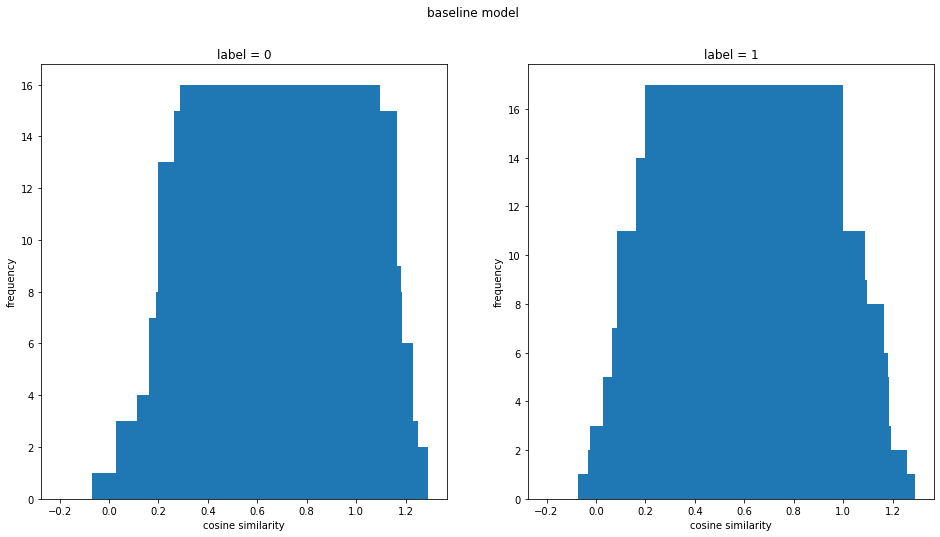

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

bins = 100
x = range(bins)

torchhist = torch.histogram(input=b_cosine_sim[indices], bins=bins, range=(b_min_x.item(), b_max_x.item()))
ax[0].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[0].set_xlabel('cosine similarity')
ax[0].set_ylabel('frequency')
ax[0].set_title('label = 0')

torchhist = torch.histogram(input=b_cosine_sim[~indices], bins=bins, range=(b_min_x.item(), b_max_x.item()))
ax[1].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[1].set_xlabel('cosine similarity')
ax[1].set_ylabel('frequency')
ax[1].set_title('label = 1')

plt.suptitle('baseline model')
plt.show()

In [ ]:
valloader = DataLoader(val_dataset, shuffle = True, batch_size = b)

In [ ]:
model_correct = 0 
baseline_model_correct = 0 
total = 0

with torch.no_grad():
  for _, vdata in enumerate(valloader):
    vimg0, vimg1, _, _, vlabel = vdata
    vimg0, vimg1, vlabel = vimg0.to(DEVICE), vimg1.to(DEVICE), vlabel.to(DEVICE)

    voutput = model(vimg0, vimg1).squeeze(1)
    b_voutput = baseline_model(vimg0, vimg1).squeeze(1)
    
    model_correct += torch.count_nonzero(vlabel == (voutput > 0.5)).item()
    baseline_model_correct += torch.count_nonzero(vlabel == (b_voutput > 0.5)).item()

    total += len(vlabel)

print('model accuracy is', model_correct/total)
print('baseline model accuracy is', baseline_model_correct/total)

model accuracy is 1.0
baseline model accuracy is 0.49514563106796117


In [ ]:
TEST_DATA_DIR = "./drive/MyDrive/capstone/test/"
TEST_SAMPLES = 256

transforms = nn.Sequential(
  T.Resize((228, 228))
)

testset = SiameseDataset(images_folder_path=TEST_DATA_DIR, transform=transforms, num_samples=TEST_SAMPLES)
testloader = DataLoader(testset, shuffle = True, batch_size = b)

threshold = 0.5

model_correct = 0 
baseline_model_correct = 0 
total = 0

with torch.no_grad():
  for _, vdata in enumerate(testloader):
    vimg0, vimg1, _, _, vlabel = vdata
    vimg0, vimg1, vlabel = vimg0.to(DEVICE), vimg1.to(DEVICE), vlabel.to(DEVICE)

    voutput = model(vimg0, vimg1).squeeze(1)
    b_voutput = baseline_model(vimg0, vimg1).squeeze(1)
    
    model_correct += torch.count_nonzero(vlabel == (voutput > 0.5)).item()
    baseline_model_correct += torch.count_nonzero(vlabel == (b_voutput > 0.5)).item()
    
    total += len(vlabel)

print('model accuracy is', model_correct/total)
print('baseline model accuracy is', baseline_model_correct/total)

model accuracy is 0.72265625
baseline model accuracy is 0.453125
